In [38]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
from scipy import stats
from datetime import datetime 
from famafrench import *
pd.options.display.float_format = '{:,.2f}'.format
import statsmodels.api as sm
import os
import warnings
warnings.filterwarnings("ignore")  #ne plus afficher les warnings 

### Base CompuStat

data extraites uniquement de CompuState, base de données de S&P 
contenant des data fondamentales et marché sur des stocks US et canada 

- gvkey = Global company key, compustat company identifier 
- datadate = date de la donnée
- at = assets (in millions)

- pstkl = preferred stock - liquidating value (in millions)
- txditc = deferred taxes adn the investment tax credit 
- pstkrv = preferred stock - redemption value 
- seq = stock holder equity (in )
- pstk = book value of preferred stocks

### Base CRSP

= on merge deux tables, la clé est permno
- crsp.msf = 
- crsp.msenames = 

variables
- permno = referentiel pour une entreprise
- permco = referentiel pour une entreprise
- date = date de la donnée
- shrcd = share code
- exchcd = exchange code

monthly alternate returns
- ret = holding period total return  
- retx = return without dividends

- shrout = shares outstanding 
- prc = price or bid/ask average 

##### MERGE :
from crsp.msf as a
left join crsp.msenames as b

on a.permno=b.permno = merger sur les boites de même id <br/>
and b.namedt<=a.date = filtrer sur les dates<br/>
and a.date<=b.nameendt<br/>
where a.date between '01/01/1959' and '12/31/2017'<br/>
and b.exchcd between 1 and 3<br/>
exchcd = [1, 2, 3] = [NYSE, AMEX, NASDAQ]

### CCM

informations trouvées sur 
- https://wrds-web.wharton.upenn.edu/wrds/tools/variable.cfm?library_id=137&file_id=66976&_ga=2.190606123.1420063168.1586248343-654272642.1586248343

- gvkey = S&P stock identifier 
- lpermno = historical CRSP permno link to compustat record
- permno = CRSP permanent issue identifier
- linktype = link type code
- linkprim = Primary link market 
- linkdt = first effective date of link
- linkenddt = last effective date of link

from crsp.ccmxpf_linktable
<br />
(linktype,1,1)='L' signifie qu'il existe un lien, sinon linktype aurait commencé par un 'N'
<br />
- linkprim ='C'  means it is primary assigned by CRSP 
- linkprim='P' means it is primary, identified by Compustat 


### Upload des données

In [2]:
upload_type = 'from_file'
conn =''

comp = compustat_block(upload_type, conn)
print('comp done')

crsp = crsp_block(upload_type, conn)
print('crsp done')

ccm = ccm_block(upload_type, conn)
print('ccm done')

# Data preparation
ccm2 = merge_ccm_comp(ccm, comp)
print('merge done')

crsp2 = marketcap_agg(crsp)
print('market cap done')

ccm_jun, nyse, crsp3 = prepare_ccm_jun_nyse_crsp3(crsp2, ccm2)

comp done
crsp done
ccm done
merge done
market cap done


### Début de la réplication des résultats 

#### Composition des portefeuilles dont nous aurons besoin

In [3]:
# COMPOSITION DES PORTEFEUILLES 2x3 AVEC TRI INDEPENDDANT
independent_sort_compo, breaks = sort_different_ways(ccm_jun, 
                                    nyse, 
                                    crsp3,
                                    is_sequential=False, 
                                    post_or_pre='', 
                                    control_variable='', 
                                    priced_variable='',
                                    breakpoints_universe='NYSE',
                                    number_port_me = 2)
print("Independent, NYSE breaks done")

independent_sort_all_names_compo, breaks_all_names = sort_different_ways(ccm_jun, 
                                    nyse, 
                                    crsp3,
                                    is_sequential=False, 
                                    post_or_pre='', 
                                    control_variable='', 
                                    priced_variable='',
                                    breakpoints_universe='all_exch',
                                    number_port_me = 2)
print("Independent, all names breaks done")

Independent, NYSE breaks done
Independent, all names breaks done


In [4]:
# COMPOSITION DES PORTEFEUILLES AVEC TRI SEQUENTIEL
combinations_to_run = [
    ['NYSE', 'post', 'beme', 'me','post SMB, NYSE breakpoints'],
    ['NYSE', 'pre', 'beme', 'me','pre SMB, NYSE breakpoints'],
    ['all_exch', 'post', 'beme', 'me','post SMB, names breakpoints'],
    ['all_exch', 'pre', 'beme', 'me','pre SMB, names breakpoints'],
    ['NYSE', 'post', 'me', 'beme','post HML, NYSE breakpoints'],
    ['NYSE', 'pre', 'me', 'beme','pre HML, NYSE breakpoints'],
    ['all_exch', 'post', 'me', 'beme','post HML, names breakpoints'],
    ['all_exch', 'pre', 'me', 'beme','pre HML, names breakpoints'],
]

In [5]:
#créer les différents 2x3 portefeuilles avec tri séquentiel
sequential_sort_portfolios = {}
for params in combinations_to_run:
    result = sort_different_ways(ccm_jun, 
                                        nyse, 
                                        crsp3,
                                        is_sequential=True, 
                                        post_or_pre=params[1], 
                                        control_variable=params[2], 
                                        priced_variable=params[3],
                                        breakpoints_universe=params[0],
                                        number_port_me=2)
    print(params, "done")
    sequential_sort_portfolios[params[4]] = result

['NYSE', 'post', 'beme', 'me', 'post SMB, NYSE breakpoints'] done
['NYSE', 'pre', 'beme', 'me', 'pre SMB, NYSE breakpoints'] done
['all_exch', 'post', 'beme', 'me', 'post SMB, names breakpoints'] done
['all_exch', 'pre', 'beme', 'me', 'pre SMB, names breakpoints'] done
['NYSE', 'post', 'me', 'beme', 'post HML, NYSE breakpoints'] done
['NYSE', 'pre', 'me', 'beme', 'pre HML, NYSE breakpoints'] done
['all_exch', 'post', 'me', 'beme', 'post HML, names breakpoints'] done
['all_exch', 'pre', 'me', 'beme', 'pre HML, names breakpoints'] done


In [6]:
#créer les différents 3x3 portefeuilles avec tri séquentiel
sequential_sort_portfolios_3x3 = {}
for params in combinations_to_run:
    result = sort_different_ways(ccm_jun, 
                                        nyse, 
                                        crsp3,
                                        is_sequential=True, 
                                        post_or_pre=params[1], 
                                        control_variable=params[2], 
                                        priced_variable=params[3],
                                        breakpoints_universe=params[0],
                                        number_port_me=3)
    print(params, "done")
    sequential_sort_portfolios_3x3[params[4]] = result


['NYSE', 'post', 'beme', 'me', 'post SMB, NYSE breakpoints'] done
['NYSE', 'pre', 'beme', 'me', 'pre SMB, NYSE breakpoints'] done
['all_exch', 'post', 'beme', 'me', 'post SMB, names breakpoints'] done
['all_exch', 'pre', 'beme', 'me', 'pre SMB, names breakpoints'] done
['NYSE', 'post', 'me', 'beme', 'post HML, NYSE breakpoints'] done
['NYSE', 'pre', 'me', 'beme', 'pre HML, NYSE breakpoints'] done
['all_exch', 'post', 'me', 'beme', 'post HML, names breakpoints'] done
['all_exch', 'pre', 'me', 'beme', 'pre HML, names breakpoints'] done


#### Création des facteurs

In [7]:
# pour les tris indépendants
indep_2x3_nyse = size_value_backtest(independent_sort_compo)
indep_2x3_names = size_value_backtest(independent_sort_all_names_compo)

In [8]:
# pour les tris séquentiels (2x3)
df_backtest_results = []
for key in sequential_sort_portfolios: 
    transi_bt = size_value_backtest(sequential_sort_portfolios[key][0])
    if 'SMB' in key:
        df_backtest_results.append(transi_bt.set_index('date').rename(columns={'WSMB':key})[key])
    elif 'HML' in key:
        df_backtest_results.append(transi_bt.set_index('date').rename(columns={'WHML':key})[key]) 
    print(key)  

post SMB, NYSE breakpoints
pre SMB, NYSE breakpoints
post SMB, names breakpoints
pre SMB, names breakpoints
post HML, NYSE breakpoints
pre HML, NYSE breakpoints
post HML, names breakpoints
pre HML, names breakpoints


In [9]:
# pour les tris séquentiels (3x3)
df_backtest_results_3x3 = []
for key in sequential_sort_portfolios_3x3: 
    transi_bt = size_value_backtest(sequential_sort_portfolios_3x3[key][0])
    if 'SMB' in key:
        df_backtest_results_3x3.append(transi_bt.set_index('date').rename(columns={'WSMB':key})[key])
    elif 'HML' in key:
        df_backtest_results_3x3.append(transi_bt.set_index('date').rename(columns={'WHML':key})[key]) 
    print(key)  

post SMB, NYSE breakpoints
pre SMB, NYSE breakpoints
post SMB, names breakpoints
pre SMB, names breakpoints
post HML, NYSE breakpoints
pre HML, NYSE breakpoints
post HML, names breakpoints
pre HML, names breakpoints


In [36]:
conn = ''
ff = ff_timeseries('from_file', conn) 

In [37]:
#reformatter les data famafrench 
ff['date'] = pd.to_datetime(ff.date, format='%Y-%m-%d')
ff['date'] = ff['date'] + MonthEnd(0)
ff = ff.set_index('date')
ff_to_use = ff.loc[df_backtest_results[0].index][['smb','hml','umd', 'mktrf']]
ff_to_use['alpha'] = np.ones((ff_to_use.shape[0], 1))
ff_to_use.sort_index(inplace=True)

#### On prépare les régressions qui seront demandées plus tard

In [12]:
def reg_on_ff_factors(df_to_regress,start_date,end_date):
    results = []
    R2_list = []
    for j in df_to_regress.columns:
        sort_type = j.split("," + " ")[0] # pour les noms des colonnes
        breaks = j.split("," + " ")[1]
        reg = sm.OLS(df_to_regress[j].loc[start_date:end_date],
                     ff_to_use.loc[start_date:end_date]).fit()
        transi = pd.DataFrame(np.array([reg.params,reg.tvalues]).T,columns=[[breaks,breaks],[sort_type,sort_type],['Coeff','t-stats']],index=reg.tvalues.index)
        results.append(transi)
        transi = pd.DataFrame(pd.Series(reg.rsquared,index=["R2"]),columns=[[breaks],[sort_type]])
        R2_list.append(transi)
    spanning_regressions = pd.concat(results,axis=1)

    R2 = pd.concat(R2_list,axis=1)
    # on affiche les résultats comme dans le paper
    def pivotDF(df):
        df_final = df.copy()
        df_final = df_final.unstack().to_frame().pivot_table(columns=[df_final.unstack().to_frame().index.get_level_values(0),df_final.unstack().to_frame().index.get_level_values(1)],index=[df_final.unstack().to_frame().index.get_level_values(3),df_final.unstack().to_frame().index.get_level_values(2)])
        return df_final
    spanning_regressions_pvt = pivotDF(spanning_regressions)
    spanning_regressions_pvt = pd.concat([spanning_regressions_pvt[0],R2])
    return spanning_regressions_pvt

#réaliser les régressions sur les facteurs de ff (2x3)
start_date = datetime(1963, 7, 1)
end_date = datetime(2014, 12, 31)
df_to_regress = pd.concat(df_backtest_results, axis=1)
spanning_regressions_pvt = reg_on_ff_factors(df_to_regress,start_date,end_date)

In [13]:
#réaliser les régressions sur les facteurs de ff (3x3)
df_to_regress = pd.concat(df_backtest_results_3x3, axis=1)
spanning_regressions_pvt_3x3 = reg_on_ff_factors(df_to_regress,start_date,end_date)

## ---- Partie 3 ---- Portfolio construction using a sequential or an independent sort

### Table 1 - Spanning regressions for 2x3 portfolios, using NYSE breakpoints

In [14]:
table1 = spanning_regressions_pvt["NYSE breakpoints"]
table1

,post HML,post SMB,pre HML,pre SMB
"(alpha, Coeff)",0.00,0.00,0.00,0.00
"(alpha, t-stats)",0.71,1.00,0.12,1.96
"(hml, Coeff)",0.98,0.19,0.94,-0.01
"(hml, t-stats)",88.93,37.37,90.25,-1.05
"(mktrf, Coeff)",-0.03,0.02,-0.01,0.01
"(mktrf, t-stats)",-4.33,6.00,-2.17,1.22
"(smb, Coeff)",0.21,1.00,0.00,0.94
"(smb, t-stats)",21.62,214.41,0.36,157.34
"(umd, Coeff)",-0.00,-0.01,-0.01,-0.01
"(umd, t-stats)",-0.18,-2.58,-2.12,-1.94


In [15]:
print(table1.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  post HML &  post SMB &  pre HML &  pre SMB \\
\midrule
(alpha, Coeff)   &      0.00 &      0.00 &     0.00 &     0.00 \\
(alpha, t-stats) &      0.71 &      1.00 &     0.12 &     1.96 \\
(hml, Coeff)     &      0.98 &      0.19 &     0.94 &    -0.01 \\
(hml, t-stats)   &     88.93 &     37.37 &    90.25 &    -1.05 \\
(mktrf, Coeff)   &     -0.03 &      0.02 &    -0.01 &     0.01 \\
(mktrf, t-stats) &     -4.33 &      6.00 &    -2.17 &     1.22 \\
(smb, Coeff)     &      0.21 &      1.00 &     0.00 &     0.94 \\
(smb, t-stats)   &     21.62 &    214.41 &     0.36 &   157.34 \\
(umd, Coeff)     &     -0.00 &     -0.01 &    -0.01 &    -0.01 \\
(umd, t-stats)   &     -0.18 &     -2.58 &    -2.12 &    -1.94 \\
R2               &      0.94 &      0.99 &     0.94 &     0.98 \\
\bottomrule
\end{tabular}



## ---- Partie 4 ---- Alternative Choices for sorting out stocks

### Figure 5 - NYSE vs Name breakpoints

In [16]:
def plot_universe(data,date,i,panel_name,plot_nb_lines,breaks_name,displayBreaks=False,breaks=None):
    # on garde que ce qui nous intéresse pour le plot
    universe = data.copy().groupby(['ffyear','permno']).aggregate({'me':'mean','beme':'mean','bmport':'last','szport':'last'}).loc[date,:]
    universe['color'] = [ord(x) for x in universe['bmport']]
    
    ax = plt.subplot(plot_nb_lines,2,i)
    plt.scatter(universe['me'],universe['beme'],s=0.4,c=universe['color'].values)
    plt.title("Panel " + panel_name + " \n US stocks universe ("+ str(date) +") \n " + breaks_name)
    plt.xlabel("Market Equity")
    plt.ylabel("Book-to-market Equity")
    
    if displayBreaks:
        breaks = breaks.loc[date,:]
        if type(breaks) == pd.core.series.Series: #independent sort
            plt.axhline(y=breaks['bm30'],linewidth=1, color='grey',xmin=0)
            plt.axhline(y=breaks['bm70'],linewidth=1, color='grey',xmin=0)
            plt.axvline(x=breaks['sizemedn'],linewidth=1, color='grey')
        else:
            if 'szport' in breaks.columns: # sequential sort
                plt.axvline(x=breaks['sizemedn'].iloc[0],linewidth=1, color='grey')
            elif 'bmport' in breaks.columns:
                plt.axhline(y=breaks['bm30'].iloc[0],linewidth=1, color='grey',xmin=0)
                plt.axhline(y=breaks['bm70'].iloc[0],linewidth=1, color='grey',xmin=0)
    
    plt.xlim(0,4e6)
    plt.ylim(0,3)

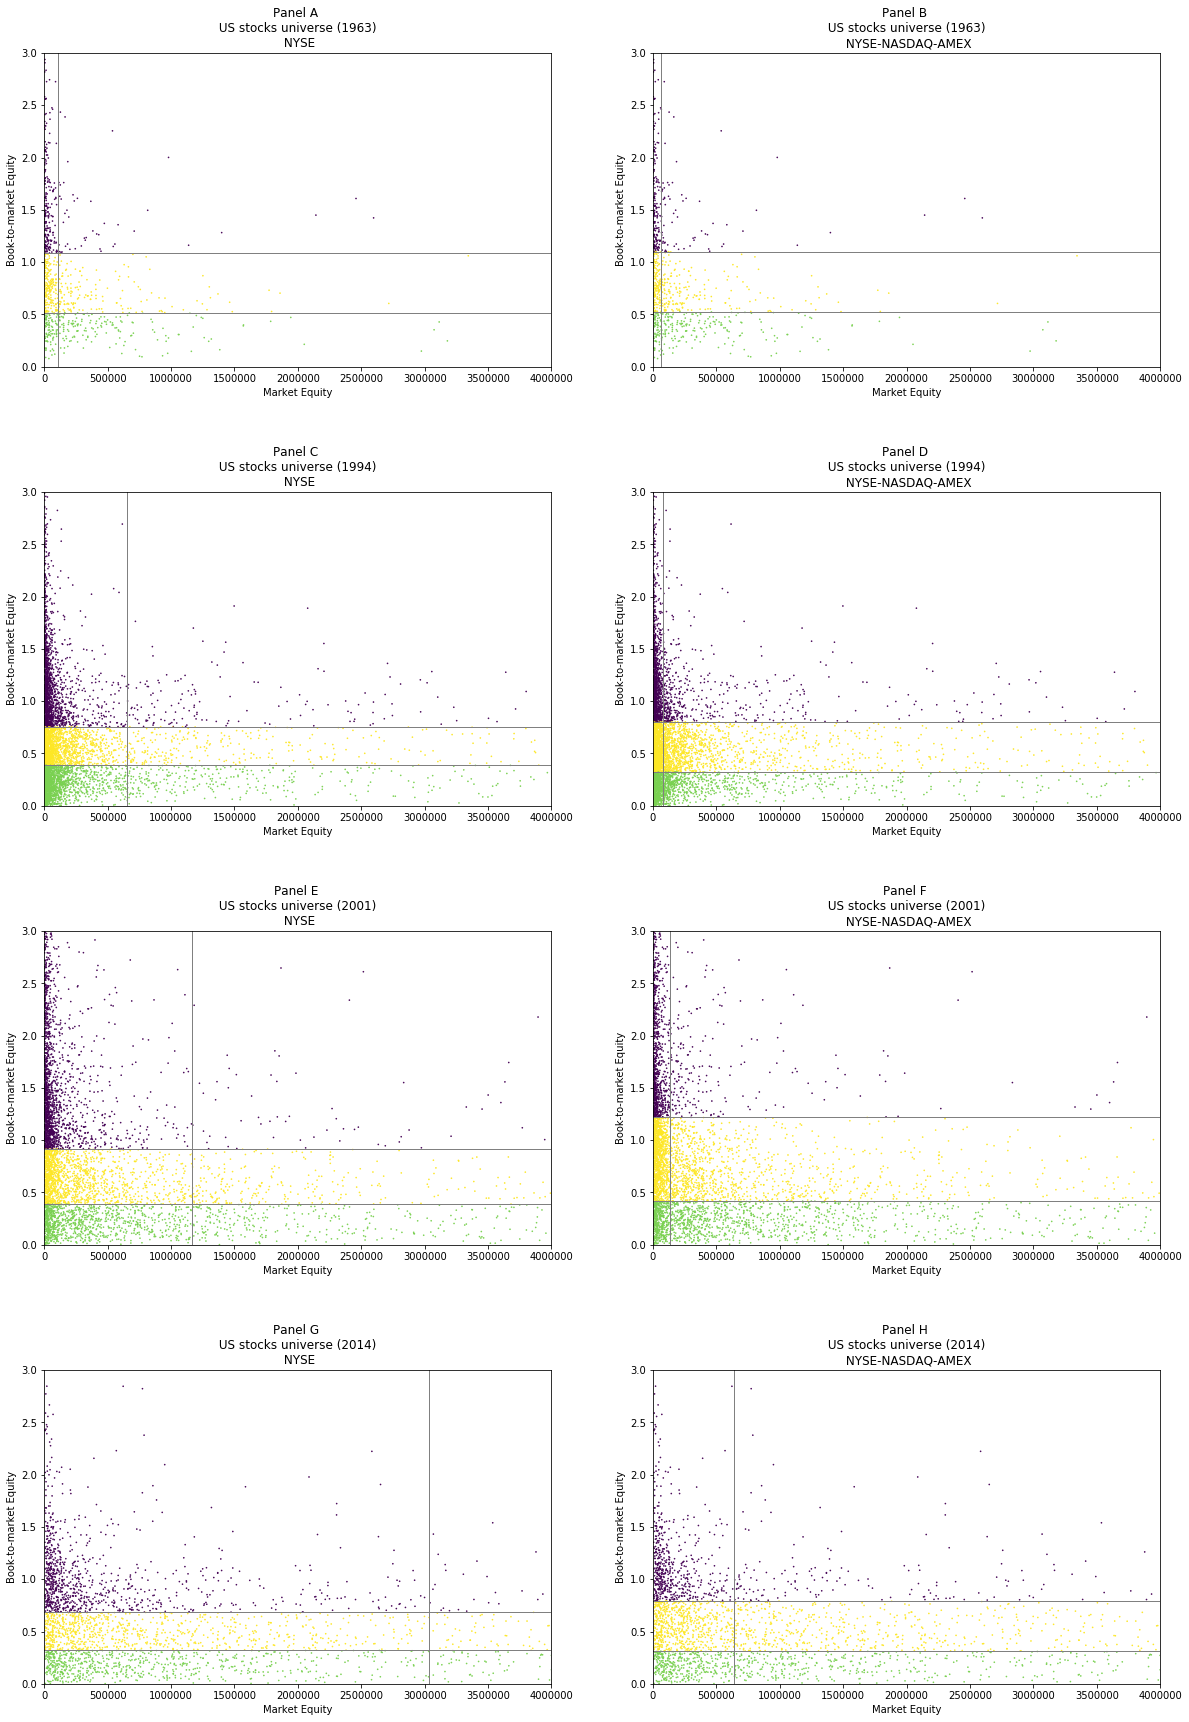

In [17]:
i=1
fig = plt.figure(figsize=(20,30))
panels=["A","B","C","D","E","F","G","H"]
for dt in [1963,1994,2001,2014]:
    plot_universe(independent_sort_compo,dt,i,panels[i-1],4,"NYSE",True,breaks) #NYSE breakpoints
    i=i+2
i=2
for dt in [1963,1994,2001,2014]:
    plot_universe(independent_sort_all_names_compo,dt,i,panels[i-1],4,"NYSE-NASDAQ-AMEX",True,breaks_all_names) #all names
    i=i+2
    
plt.subplots_adjust(hspace=0.4)
plt.savefig('Figure5.png')
plt.show()

### Figure 6 - Relative stock distribution among 2x3 portfolios

In [18]:
def relative_stock_distribution(data,plt_title,startDate,endDate):
    # on récupère la stratification des portefeuilles 2x3 d'après la méthode de tri de Fama et French (NYSE breakpoints)
    panel = data[['jdate','bmport','szport']].copy().set_index('jdate')
    panel = panel.loc[startDate:endDate]
    # nombre de stocks par portefeuille, à chaque date (de 1963-06-30 à 2014-12-31)
    plotPanel = panel.pivot_table(columns=['szport','bmport'],index=panel.index,aggfunc=len).reindex([('S', 'L'), ('S', 'M'), ('S', 'H'), ('B', 'L'), ('B', 'M'), ('B', 'H')],axis=1)
    # répartition par portefeuille, à chaque date
    plotPanel_pct = plotPanel.apply(lambda x: x/x.sum(),axis=1)
    
    # graph la distribution
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1) #pour gérer la légende
    plt.stackplot(plotPanel_pct.index,np.array(plotPanel_pct).T,labels=plotPanel_pct.columns)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], loc='best')
    plt.title(plt_title)
    plt.savefig(plt_title+".png")
    plt.show()
    
    # statistiques
    display(plotPanel.describe().drop(['count','25%','50%','75%']))
    print(plotPanel.describe().drop(['count','25%','50%','75%']).to_latex())

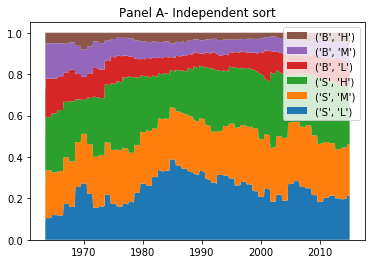

szport        S                        B              
bmport        L        M        H      L      M      H
mean     952.30   988.41 1,034.96 354.04 296.16 137.26
std      459.67   399.86   417.10 112.18  56.29  39.89
min       57.00   114.00   148.00 135.00 140.00  44.00
max    1,758.00 1,944.00 2,056.00 803.00 437.00 221.00

\begin{tabular}{lrrrrrr}
\toprule
szport & \multicolumn{3}{l}{S} & \multicolumn{3}{l}{B} \\
bmport &        L &        M &        H &      L &      M &      H \\
\midrule
mean &   952.30 &   988.41 & 1,034.96 & 354.04 & 296.16 & 137.26 \\
std  &   459.67 &   399.86 &   417.10 & 112.18 &  56.29 &  39.89 \\
min  &    57.00 &   114.00 &   148.00 & 135.00 & 140.00 &  44.00 \\
max  & 1,758.00 & 1,944.00 & 2,056.00 & 803.00 & 437.00 & 221.00 \\
\bottomrule
\end{tabular}



In [19]:
relative_stock_distribution(independent_sort_compo,'Panel A- Independent sort','1963-06-30','2014-12-31')

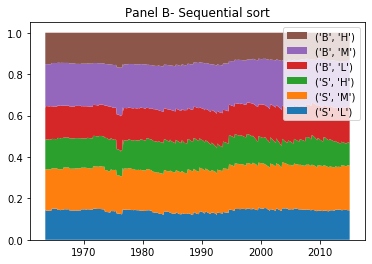

szport      S                        B                
bmport      L        M      H        L        M      H
mean   528.08   783.63 502.61   593.84   818.46 536.37
std    197.83   299.13 177.27   213.89   301.68 180.30
min     95.00   120.00  91.00   100.00   133.00  99.00
max    993.00 1,446.00 910.00 1,008.00 1,392.00 856.00

\begin{tabular}{lrrrrrr}
\toprule
szport & \multicolumn{3}{l}{S} & \multicolumn{3}{l}{B} \\
bmport &      L &        M &      H &        L &        M &      H \\
\midrule
mean & 528.08 &   783.63 & 502.61 &   593.84 &   818.46 & 536.37 \\
std  & 197.83 &   299.13 & 177.27 &   213.89 &   301.68 & 180.30 \\
min  &  95.00 &   120.00 &  91.00 &   100.00 &   133.00 &  99.00 \\
max  & 993.00 & 1,446.00 & 910.00 & 1,008.00 & 1,392.00 & 856.00 \\
\bottomrule
\end{tabular}



In [20]:
relative_stock_distribution(sequential_sort_portfolios['post SMB, names breakpoints'][0],'Panel B- Sequential sort','1963-06-30','2014-12-31')

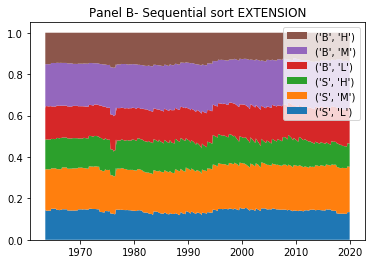

szport      S                        B                
bmport      L        M      H        L        M      H
mean   520.02   776.84 489.17   590.71   811.67 526.81
std    190.99   286.48 174.73   204.51   288.88 174.93
min     95.00   120.00  91.00   100.00   133.00  99.00
max    993.00 1,446.00 910.00 1,008.00 1,392.00 856.00

\begin{tabular}{lrrrrrr}
\toprule
szport & \multicolumn{3}{l}{S} & \multicolumn{3}{l}{B} \\
bmport &      L &        M &      H &        L &        M &      H \\
\midrule
mean & 520.02 &   776.84 & 489.17 &   590.71 &   811.67 & 526.81 \\
std  & 190.99 &   286.48 & 174.73 &   204.51 &   288.88 & 174.93 \\
min  &  95.00 &   120.00 &  91.00 &   100.00 &   133.00 &  99.00 \\
max  & 993.00 & 1,446.00 & 910.00 & 1,008.00 & 1,392.00 & 856.00 \\
\bottomrule
\end{tabular}



In [21]:
# EXTENSION : -> 2020
relative_stock_distribution(sequential_sort_portfolios['post SMB, names breakpoints'][0],'Panel B- Sequential sort EXTENSION','1963-06-30','2019-12-31')

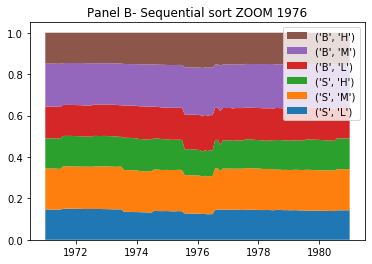

szport      S                    B              
bmport      L      M      H      L      M      H
mean   443.63 622.87 449.05 491.35 664.16 485.30
std     95.28 133.06  97.95 113.84 158.28 114.69
min    266.00 362.00 268.00 281.00 383.00 275.00
max    553.00 764.00 561.00 587.00 798.00 580.00

\begin{tabular}{lrrrrrr}
\toprule
szport & \multicolumn{3}{l}{S} & \multicolumn{3}{l}{B} \\
bmport &      L &      M &      H &      L &      M &      H \\
\midrule
mean & 443.63 & 622.87 & 449.05 & 491.35 & 664.16 & 485.30 \\
std  &  95.28 & 133.06 &  97.95 & 113.84 & 158.28 & 114.69 \\
min  & 266.00 & 362.00 & 268.00 & 281.00 & 383.00 & 275.00 \\
max  & 553.00 & 764.00 & 561.00 & 587.00 & 798.00 & 580.00 \\
\bottomrule
\end{tabular}



In [22]:
relative_stock_distribution(sequential_sort_portfolios['post SMB, names breakpoints'][0],'Panel B- Sequential sort ZOOM 1976','1970-12-31','1980-12-31')

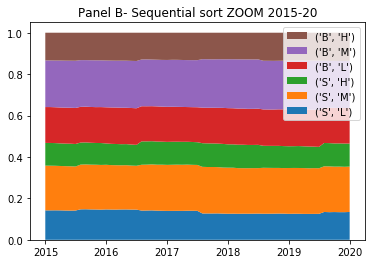

szport      S                    B              
bmport      L      M      H      L      M      H
mean   437.36 706.87 350.66 558.70 741.61 428.33
std     38.64  20.20  14.65  16.74  14.16  16.91
min    385.00 670.00 317.00 531.00 715.00 393.00
max    510.00 749.00 380.00 598.00 782.00 459.00

\begin{tabular}{lrrrrrr}
\toprule
szport & \multicolumn{3}{l}{S} & \multicolumn{3}{l}{B} \\
bmport &      L &      M &      H &      L &      M &      H \\
\midrule
mean & 437.36 & 706.87 & 350.66 & 558.70 & 741.61 & 428.33 \\
std  &  38.64 &  20.20 &  14.65 &  16.74 &  14.16 &  16.91 \\
min  & 385.00 & 670.00 & 317.00 & 531.00 & 715.00 & 393.00 \\
max  & 510.00 & 749.00 & 380.00 & 598.00 & 782.00 & 459.00 \\
\bottomrule
\end{tabular}



In [23]:
relative_stock_distribution(sequential_sort_portfolios['post SMB, names breakpoints'][0],'Panel B- Sequential sort ZOOM 2015-20','2014-12-31','2020-03-30')

### Figure 7- Relative stock distribution under Independent vs Dependent sort

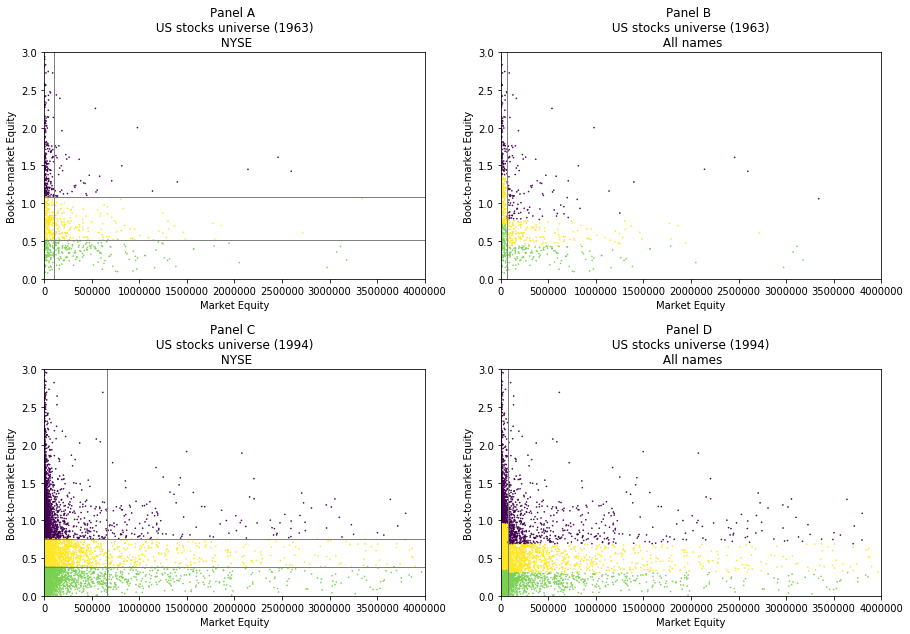

In [24]:
i=1
panels=["A","B","C","D","E","F","G","H"]
fig = plt.figure(figsize=(15,10))
for dt in [1963,1994]:
    plot_universe(independent_sort_compo,dt,i,panels[i-1],2,"NYSE",True,breaks)
    i=i+2
i=2
for dt in [1963,1994]:
    plot_universe(sequential_sort_portfolios['post SMB, names breakpoints'][0],dt,i,panels[i-1],2,"All names",True,sequential_sort_portfolios['post SMB, names breakpoints'][1])
    i=i+2

plt.subplots_adjust(hspace=0.4)
plt.savefig("Figure7.png")
plt.show()

### Table 2 - Spanning regressions for 2x3 portfolios, using both breakpoints

In [25]:
table2A = spanning_regressions_pvt[[( 'NYSE breakpoints', 'post SMB'),( 'NYSE breakpoints', 'pre SMB'),( 'names breakpoints', 'post SMB'),( 'names breakpoints', 'pre SMB')]]
table2B = spanning_regressions_pvt[[( 'NYSE breakpoints', 'post HML'),( 'NYSE breakpoints', 'pre HML'),( 'names breakpoints', 'post HML'),( 'names breakpoints', 'pre HML')]]
display(table2A)
display(table2B)

NYSE breakpoints         names breakpoints        
                         post SMB pre SMB          post SMB pre SMB
(alpha, Coeff)               0.00    0.00             -0.00   -0.00
(alpha, t-stats)             1.00    1.96             -0.44   -0.33
(hml, Coeff)                 0.19   -0.01              0.13   -0.07
(hml, t-stats)              37.37   -1.05              5.04   -2.87
(mktrf, Coeff)               0.02    0.01             -0.06   -0.08
(mktrf, t-stats)             6.00    1.22             -3.54   -4.90
(smb, Coeff)                 1.00    0.94              1.26    1.20
(smb, t-stats)             214.41  157.34             52.34   52.91
(umd, Coeff)                -0.01   -0.01             -0.01   -0.01
(umd, t-stats)              -2.58   -1.94             -0.53   -0.85
R2                           0.99    0.98              0.82    0.83

NYSE breakpoints         names breakpoints        
                         post HML pre HML          post HML pre HML
(alpha, Coeff)               0.00    0.00              0.00    0.00
(alpha, t-stats)             0.71    0.12              5.63    4.50
(hml, Coeff)                 0.98    0.94              0.93    0.96
(hml, t-stats)              88.93   90.25             45.74   51.51
(mktrf, Coeff)              -0.03   -0.01             -0.08   -0.02
(mktrf, t-stats)            -4.33   -2.17             -6.41   -1.92
(smb, Coeff)                 0.21    0.00              0.05   -0.08
(smb, t-stats)              21.62    0.36              2.95   -4.49
(umd, Coeff)                -0.00   -0.01              0.01   -0.01
(umd, t-stats)              -0.18   -2.12              0.92   -1.04
R2                           0.94    0.94              0.81    0.84

In [26]:
print(table2A.to_latex())
print(table2B.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} & \multicolumn{2}{l}{NYSE breakpoints} & \multicolumn{2}{l}{names breakpoints} \\
{} &         post SMB & pre SMB &          post SMB & pre SMB \\
\midrule
(alpha, Coeff)   &             0.00 &    0.00 &             -0.00 &   -0.00 \\
(alpha, t-stats) &             1.00 &    1.96 &             -0.44 &   -0.33 \\
(hml, Coeff)     &             0.19 &   -0.01 &              0.13 &   -0.07 \\
(hml, t-stats)   &            37.37 &   -1.05 &              5.04 &   -2.87 \\
(mktrf, Coeff)   &             0.02 &    0.01 &             -0.06 &   -0.08 \\
(mktrf, t-stats) &             6.00 &    1.22 &             -3.54 &   -4.90 \\
(smb, Coeff)     &             1.00 &    0.94 &              1.26 &    1.20 \\
(smb, t-stats)   &           214.41 &  157.34 &             52.34 &   52.91 \\
(umd, Coeff)     &            -0.01 &   -0.01 &             -0.01 &   -0.01 \\
(umd, t-stats)   &            -2.58 &   -1.94 &             -0.53 &   -0.85 \\
R2               & 

### Table 3 - Spanning regressions for 3x3 portfolios, using both breakpoints

In [27]:
table3A = spanning_regressions_pvt_3x3[[( 'NYSE breakpoints', 'post SMB'),( 'NYSE breakpoints', 'pre SMB'),( 'names breakpoints', 'post SMB'),( 'names breakpoints', 'pre SMB')]]
table3B = spanning_regressions_pvt_3x3[[( 'NYSE breakpoints', 'post HML'),( 'NYSE breakpoints', 'pre HML'),( 'names breakpoints', 'post HML'),( 'names breakpoints', 'pre HML')]]
display(table3A)
display(table3B)

NYSE breakpoints         names breakpoints        
                         post SMB pre SMB          post SMB pre SMB
(alpha, Coeff)               0.00    0.00              0.00    0.00
(alpha, t-stats)             0.15    0.72              0.68    0.29
(hml, Coeff)                 0.27   -0.04              0.14   -0.10
(hml, t-stats)              23.02   -3.76              3.24   -2.30
(mktrf, Coeff)               0.01   -0.01             -0.15   -0.16
(mktrf, t-stats)             1.83   -2.21             -5.49   -5.95
(smb, Coeff)                 1.23    1.18              1.37    1.36
(smb, t-stats)             117.66  131.25             35.72   36.20
(umd, Coeff)                -0.01   -0.01             -0.04   -0.04
(umd, t-stats)              -0.76   -1.57             -1.34   -1.41
R2                           0.96    0.97              0.68    0.70

NYSE breakpoints         names breakpoints        
                         post HML pre HML          post HML pre HML
(alpha, Coeff)               0.00    0.00              0.00    0.00
(alpha, t-stats)             2.26    0.29              5.61    4.33
(hml, Coeff)                 0.96    0.90              0.86    0.83
(hml, t-stats)              72.14   61.75             35.44   38.10
(mktrf, Coeff)              -0.05   -0.01             -0.07   -0.03
(mktrf, t-stats)            -6.08   -1.32             -4.79   -1.94
(smb, Coeff)                 0.15   -0.04             -0.00   -0.10
(smb, t-stats)              12.60   -2.93             -0.12   -5.12
(umd, Coeff)                 0.01   -0.02             -0.00    0.01
(umd, t-stats)               1.43   -1.87             -0.16    0.72
R2                           0.91    0.88              0.72    0.75

In [28]:
print(table3A.to_latex())
print(table3B.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} & \multicolumn{2}{l}{NYSE breakpoints} & \multicolumn{2}{l}{names breakpoints} \\
{} &         post SMB & pre SMB &          post SMB & pre SMB \\
\midrule
(alpha, Coeff)   &             0.00 &    0.00 &              0.00 &    0.00 \\
(alpha, t-stats) &             0.15 &    0.72 &              0.68 &    0.29 \\
(hml, Coeff)     &             0.27 &   -0.04 &              0.14 &   -0.10 \\
(hml, t-stats)   &            23.02 &   -3.76 &              3.24 &   -2.30 \\
(mktrf, Coeff)   &             0.01 &   -0.01 &             -0.15 &   -0.16 \\
(mktrf, t-stats) &             1.83 &   -2.21 &             -5.49 &   -5.95 \\
(smb, Coeff)     &             1.23 &    1.18 &              1.37 &    1.36 \\
(smb, t-stats)   &           117.66 &  131.25 &             35.72 &   36.20 \\
(umd, Coeff)     &            -0.01 &   -0.01 &             -0.04 &   -0.04 \\
(umd, t-stats)   &            -0.76 &   -1.57 &             -1.34 &   -1.41 \\
R2               & 

In [29]:
# EXTENSION

#réaliser les régressions sur les facteurs de ff (2x3)

df_to_regress = pd.concat(df_backtest_results, axis=1)
spanning_regressions_pvt_extend = reg_on_ff_factors(df_to_regress,datetime(2014, 12, 31),datetime(2019, 12, 31))
df_to_regress = pd.concat(df_backtest_results_3x3, axis=1)
spanning_regressions_pvt_3x3__extend = reg_on_ff_factors(df_to_regress,datetime(2014, 12, 31),datetime(2019, 12, 31))

In [30]:
table2A_extend = spanning_regressions_pvt_extend[[( 'NYSE breakpoints', 'post SMB'),( 'NYSE breakpoints', 'pre SMB'),( 'names breakpoints', 'post SMB'),( 'names breakpoints', 'pre SMB')]]
table2B_extend = spanning_regressions_pvt_extend[[( 'NYSE breakpoints', 'post HML'),( 'NYSE breakpoints', 'pre HML'),( 'names breakpoints', 'post HML'),( 'names breakpoints', 'pre HML')]]
display(table2A_extend)
display(table2B_extend)
table3A_extend = spanning_regressions_pvt_3x3__extend[[( 'NYSE breakpoints', 'post SMB'),( 'NYSE breakpoints', 'pre SMB'),( 'names breakpoints', 'post SMB'),( 'names breakpoints', 'pre SMB')]]
table3B_extend = spanning_regressions_pvt_3x3__extend[[( 'NYSE breakpoints', 'post HML'),( 'NYSE breakpoints', 'pre HML'),( 'names breakpoints', 'post HML'),( 'names breakpoints', 'pre HML')]]
display(table3A_extend)
display(table3B_extend)

NYSE breakpoints         names breakpoints        
                         post SMB pre SMB          post SMB pre SMB
(alpha, Coeff)              -0.00    0.00              0.00    0.00
(alpha, t-stats)            -0.73    1.01              0.35    1.11
(hml, Coeff)                 0.20    0.07              0.14   -0.05
(hml, t-stats)              12.46    4.16              1.99   -0.95
(mktrf, Coeff)               0.01    0.01             -0.14   -0.12
(mktrf, t-stats)             0.96    0.60             -2.89   -3.26
(smb, Coeff)                 0.96    0.90              1.17    1.06
(smb, t-stats)              65.89   56.71             18.58   21.69
(umd, Coeff)                -0.01    0.04             -0.07   -0.03
(umd, t-stats)              -0.55    2.78             -1.28   -0.80
R2                           0.99    0.98              0.88    0.90

NYSE breakpoints         names breakpoints        
                         post HML pre HML          post HML pre HML
(alpha, Coeff)              -0.00   -0.00              0.00    0.00
(alpha, t-stats)            -0.09   -1.62              0.19    0.12
(hml, Coeff)                 0.84    0.77              0.89    0.81
(hml, t-stats)              23.81   23.25             15.81   11.16
(mktrf, Coeff)              -0.09   -0.12             -0.15   -0.14
(mktrf, t-stats)            -3.71   -5.24             -3.79   -2.77
(smb, Coeff)                 0.15   -0.00             -0.14   -0.08
(smb, t-stats)               4.69   -0.07             -2.62   -1.27
(umd, Coeff)                -0.08   -0.11             -0.06   -0.15
(umd, t-stats)              -3.20   -4.49             -1.35   -2.79
R2                           0.95    0.95              0.89    0.82

NYSE breakpoints         names breakpoints        
                         post SMB pre SMB          post SMB pre SMB
(alpha, Coeff)               0.00    0.00             -0.00   -0.00
(alpha, t-stats)             0.63    1.62             -0.25   -0.20
(hml, Coeff)                 0.24    0.03             -0.13   -0.17
(hml, t-stats)               5.92    1.08             -1.07   -1.47
(mktrf, Coeff)              -0.05   -0.05             -0.22   -0.25
(mktrf, t-stats)            -1.62   -2.40             -2.71   -3.11
(smb, Coeff)                 1.14    1.11              1.00    1.05
(smb, t-stats)              30.19   40.18              9.02    9.83
(umd, Coeff)                -0.03    0.01             -0.22   -0.13
(umd, t-stats)              -1.05    0.54             -2.41   -1.46
R2                           0.95    0.97              0.63    0.64

NYSE breakpoints         names breakpoints        
                         post HML pre HML          post HML pre HML
(alpha, Coeff)               0.00   -0.00              0.00    0.00
(alpha, t-stats)             1.04   -0.54              1.78    1.68
(hml, Coeff)                 0.85    0.78              0.70    0.79
(hml, t-stats)              21.40   15.24              6.23    8.54
(mktrf, Coeff)              -0.14   -0.11             -0.17   -0.17
(mktrf, t-stats)            -5.04   -3.20             -2.23   -2.72
(smb, Coeff)                 0.03   -0.05             -0.28   -0.12
(smb, t-stats)               0.81   -1.06             -2.68   -1.42
(umd, Coeff)                -0.09   -0.11             -0.17   -0.02
(umd, t-stats)              -3.06   -2.86             -2.04   -0.31
R2                           0.94    0.89              0.63    0.70

In [31]:
print(table2A_extend.to_latex())
print(table2B_extend.to_latex())
print(table3A_extend.to_latex())
print(table3B_extend.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} & \multicolumn{2}{l}{NYSE breakpoints} & \multicolumn{2}{l}{names breakpoints} \\
{} &         post SMB & pre SMB &          post SMB & pre SMB \\
\midrule
(alpha, Coeff)   &            -0.00 &    0.00 &              0.00 &    0.00 \\
(alpha, t-stats) &            -0.73 &    1.01 &              0.35 &    1.11 \\
(hml, Coeff)     &             0.20 &    0.07 &              0.14 &   -0.05 \\
(hml, t-stats)   &            12.46 &    4.16 &              1.99 &   -0.95 \\
(mktrf, Coeff)   &             0.01 &    0.01 &             -0.14 &   -0.12 \\
(mktrf, t-stats) &             0.96 &    0.60 &             -2.89 &   -3.26 \\
(smb, Coeff)     &             0.96 &    0.90 &              1.17 &    1.06 \\
(smb, t-stats)   &            65.89 &   56.71 &             18.58 &   21.69 \\
(umd, Coeff)     &            -0.01 &    0.04 &             -0.07 &   -0.03 \\
(umd, t-stats)   &            -0.55 &    2.78 &             -1.28 &   -0.80 \\
R2               & 

# ---- Partie 5 ---- Portfolio Diversification and the Effect on Factor Construction Biases

### Table 4 - Stock Distribution among Portfolios srted on Correlated Characteristics

In [41]:
#first, we compute BEME as the inverse of ME 
ccm_jun_inverse = ccm_jun.copy()
ccm_jun_inverse['beme'] = -ccm_jun_inverse['me'].replace([-np.inf, np.inf], np.nan)
nyse_inverse = nyse.copy()
nyse_inverse['beme'] = - nyse_inverse['me'].replace([-np.inf, np.inf], np.nan)

In [42]:
#list of portfolio to build, only the Way of sorting, 
#the number of subportfolio for Size and the breakpoints universe change 
pt_to_build = [
    [False, 2, 'NYSE','Panel A: Independent - 2x3 - NYSE', 'pre','beme','me'],
    [False, 2, 'all_exch', 'Panel B: Independent - 2x3 - Name', 'pre', 'beme', 'me'],
    [False, 3, 'NYSE', 'Panel C: Independent - 3x3 - NYSE', 'pre', 'beme', 'me'],
    [False, 3, 'all_exch', 'Panel D: Independent - 3x3 - Name', 'pre', 'beme', 'me'],
    [True, 2, 'NYSE', 'Panel E: Dependent - 2x3 - NYSE (First sort on HML)', 'pre', 'beme','me'],
    [True, 2, 'NYSE', 'Panel E: Dependent - 2x3 - NYSE (First sort on SMB)', 'pre', 'me','beme'],
    [True, 2, 'all_exch', 'Panel F: Dependent - 2x3 - Name (First sort on HML)', 'pre', 'beme','me'],
    [True, 2, 'all_exch', 'Panel F: Dependent - 2x3 - Name (First sort on SMB)', 'pre', 'me','beme'],
    [True, 3, 'NYSE', 'Panel G: Dependent - 3x3 - NYSE (First sort on HML)', 'pre', 'beme','me'],
    [True, 3, 'NYSE', 'Panel G: Dependent - 3x3 - NYSE (First sort on SMB)', 'pre', 'me','beme'],
    [True, 3, 'all_exch', 'Panel H: Dependent - 3x3 - Name (First sort on HML)', 'pre', 'beme','me'],
    [True, 3, 'all_exch', 'Panel H: Dependent - 3x3 - Name (First sort on SMB)', 'pre', 'me','beme'],
]

In [72]:
#sauvegarder les valeurs générées 
to_download = True #variable pour choisir si l'on veut downloader les data des fichiers pickle ou alors les computer (ce qui peut prendre beaucoup de temps)
start_date = datetime(1963, 7, 31)
end_date = datetime(2015, 1, 1)
bt_built = []
pt_built = []

if to_download:
    link_pt = r'data/Partie_5/portefeuilles/'
    link_bt = r'data/Partie_5/backtests/'
    for i in pt_to_build[:]:
        print(i)
        if 'Dependent' in i[3]:
            name = '_'.join(map(str, i[:3])) + '_dependent_' + '_'.join(i[-2::]) + '.pkl'
        else:
            name = '_'.join(map(str, i[:3])) + '_independent_' + '_'.join(i[-2::]) + '.pkl'

        bt_built.append(pd.read_pickle(link_bt + name))
        pt_built.append(pd.read_pickle(link_pt + name))        
else:
    for i in pt_to_build[:]: 
        print(i)
        transi_pt = sort_different_ways(ccm_jun_inverse, 
                                            nyse_inverse, 
                                            crsp3,
                                            is_sequential=i[0], #varie 
                                            post_or_pre=i[4], 
                                            control_variable=i[5], 
                                            priced_variable=i[6],
                                            breakpoints_universe=i[2],  #ça varie
                                            number_port_me=i[1],
                                            is_inverse=True)  #ça varie

        bt = size_value_backtest(transi_pt[0])
        pt_built.append(transi_pt[0])
        bt_built.append(bt[['date','WHML','WSMB']].set_index('date').loc[start_date:end_date])

[False, 2, 'NYSE', 'Panel A: Independent - 2x3 - NYSE', 'pre', 'beme', 'me']
[False, 2, 'all_exch', 'Panel B: Independent - 2x3 - Name', 'pre', 'beme', 'me']
[False, 3, 'NYSE', 'Panel C: Independent - 3x3 - NYSE', 'pre', 'beme', 'me']
[False, 3, 'all_exch', 'Panel D: Independent - 3x3 - Name', 'pre', 'beme', 'me']
[True, 2, 'NYSE', 'Panel E: Dependent - 2x3 - NYSE (First sort on HML)', 'pre', 'beme', 'me']
[True, 2, 'NYSE', 'Panel E: Dependent - 2x3 - NYSE (First sort on SMB)', 'pre', 'me', 'beme']
[True, 2, 'all_exch', 'Panel F: Dependent - 2x3 - Name (First sort on HML)', 'pre', 'beme', 'me']
[True, 2, 'all_exch', 'Panel F: Dependent - 2x3 - Name (First sort on SMB)', 'pre', 'me', 'beme']
[True, 3, 'NYSE', 'Panel G: Dependent - 3x3 - NYSE (First sort on HML)', 'pre', 'beme', 'me']
[True, 3, 'NYSE', 'Panel G: Dependent - 3x3 - NYSE (First sort on SMB)', 'pre', 'me', 'beme']
[True, 3, 'all_exch', 'Panel H: Dependent - 3x3 - Name (First sort on HML)', 'pre', 'beme', 'me']
[True, 3, 'all

In [73]:
#fonction pour calculer la distribution des stocks pour chaque sous portefeuille
def compute_stock_distribution(name, df):
    c = df[['jdate','bmport','szport']]
    c['final_port'] = c['szport'] + c['bmport']
    to_concat = [
        c.groupby(['jdate','final_port']).count()['bmport'].unstack(level=[1]).fillna(0).loc[start_date:end_date].mean(),
        c.groupby(['jdate','final_port']).count()['bmport'].unstack(level=[1]).fillna(0).loc[start_date:end_date].std(),
        c.groupby(['jdate','final_port']).count()['bmport'].unstack(level=[1]).fillna(0).loc[start_date:end_date].min(),
        c.groupby(['jdate','final_port']).count()['bmport'].unstack(level=[1]).fillna(0).loc[start_date:end_date].max(),
    ]
    final_df = pd.concat(to_concat, axis=1)
    final_df.columns=['Mean','Std','Min','Max']
    final_df.index.name = name
    final_df = final_df.T
    
    for i in ['SL','SM','SH','BL','BM','BH','ML','MM','MH']:
        if i not in final_df.columns:
            final_df[i] = 0 
    return final_df[['SL','SM','SH','BL','BM','BH','ML','MM','MH']]

In [74]:
listing_distrib = []
for i in zip(pt_built[:], pt_to_build[:], bt_built[:]):
    print(i[1])
    listing_distrib.append(compute_stock_distribution(i[1][-1], i[0]))

[False, 2, 'NYSE', 'Panel A: Independent - 2x3 - NYSE', 'pre', 'beme', 'me']
[False, 2, 'all_exch', 'Panel B: Independent - 2x3 - Name', 'pre', 'beme', 'me']
[False, 3, 'NYSE', 'Panel C: Independent - 3x3 - NYSE', 'pre', 'beme', 'me']
[False, 3, 'all_exch', 'Panel D: Independent - 3x3 - Name', 'pre', 'beme', 'me']
[True, 2, 'NYSE', 'Panel E: Dependent - 2x3 - NYSE (First sort on HML)', 'pre', 'beme', 'me']
[True, 2, 'NYSE', 'Panel E: Dependent - 2x3 - NYSE (First sort on SMB)', 'pre', 'me', 'beme']
[True, 2, 'all_exch', 'Panel F: Dependent - 2x3 - Name (First sort on HML)', 'pre', 'beme', 'me']
[True, 2, 'all_exch', 'Panel F: Dependent - 2x3 - Name (First sort on SMB)', 'pre', 'me', 'beme']
[True, 3, 'NYSE', 'Panel G: Dependent - 3x3 - NYSE (First sort on HML)', 'pre', 'beme', 'me']
[True, 3, 'NYSE', 'Panel G: Dependent - 3x3 - NYSE (First sort on SMB)', 'pre', 'me', 'beme']
[True, 3, 'all_exch', 'Panel H: Dependent - 3x3 - Name (First sort on HML)', 'pre', 'beme', 'me']
[True, 3, 'all

In [75]:
df_distri = pd.concat(listing_distrib, axis=0).T
df_distri.columns = pd.MultiIndex.from_product([[i[3] for i in pt_to_build[:]], ['Mean','Std','Min','Max']])
df_distri.T.iloc[:].astype(int)

SL    SM    SH  \
Panel A: Independent - 2x3 - NYSE                  Mean    0   477  2628   
                                                   Std     0   140  1099   
                                                   Min     0   164   413   
                                                   Max     0   822  4865   
Panel B: Independent - 2x3 - Name                  Mean    0   765  1141   
                                                   Std     0   272   424   
                                                   Min     0   195   281   
                                                   Max     0  1310  2118   
Panel C: Independent - 3x3 - NYSE                  Mean    0     1  2628   
                                                   Std     0     1  1099   
                                                   Min     0     0   413   
                                                   Max     0     9  4865   
Panel D: Independent - 3x3 - Name                  Mean    0     1  1141   
                                                   Std     0     1   424   
                                                   Min     0     0   281   
                                                   Max     0     4  2118   
Panel E: Dependent - 2x3 - NYSE (First sort on ... Mean  233   475  2107   
                                                   Std    53   142   910   
                                                   Min   113   162   277   
                                                   Max   383   822  3979   
Panel E: Dependent - 2x3 - NYSE (First sort on ... Mean  339   657  2108   
                                                   Std    98   244   910   
                                                   Min   121   176   277   
                                                   Max   595  1138  3980   
Panel F: Dependent - 2x3 - Name (First sort on ... Mean  597   763   558   
                                                   Std   205   273   205   
                                                   Min   147   192   135   
                                                   Max   964  1310  1053   
Panel F: Dependent - 2x3 - Name (First sort on ... Mean  567   776   561   
                                                   Std   203   290   205   
                                                   Min   142   196   135   
                                                   Max   968  1407  1054   
Panel G: Dependent - 3x3 - NYSE (First sort on ... Mean  143   306  1774   
                                                   Std    33    95   765   
                                                   Min    68   101   205   
                                                   Max   228   524  3304   
Panel G: Dependent - 3x3 - NYSE (First sort on ... Mean  282   572  1774   
                                                   Std   103   255   765   
                                                   Min    78   128   205   
                                                   Max   507  1125  3304   
Panel H: Dependent - 3x3 - Name (First sort on ... Mean  354   460   325   
                                                   Std   120   168   119   
                                                   Min    89   118    77   
                                                   Max   565   803   629   
Panel H: Dependent - 3x3 - Name (First sort on ... Mean  348   467   325   
                                                   Std   132   176   119   
                                                   Min    86   116    77   
                                                   Max   636   859   629   

                                                           BL    BM    BH  \
Panel A: Independent - 2x3 - NYSE                  Mean   445   348     0   
                                                   Std     96    89     0   
                                                   Min    223   156     0   
                         

In [76]:
print(df_distri.T.astype(int).to_latex())

\begin{tabular}{llrrrrrrrrr}
\toprule
                                                    &     &   SL &    SM &    SH &    BL &    BM &    BH &   ML &    MM &    MH \\
\midrule
Panel A: Independent - 2x3 - NYSE & Mean &    0 &   477 &  2628 &   445 &   348 &     0 &    0 &     0 &     0 \\
                                                    & Std &    0 &   140 &  1099 &    96 &    89 &     0 &    0 &     0 &     0 \\
                                                    & Min &    0 &   164 &   413 &   223 &   156 &     0 &    0 &     0 &     0 \\
                                                    & Max &    0 &   822 &  4865 &   716 &   604 &     0 &    0 &     0 &     0 \\
Panel B: Independent - 2x3 - Name & Mean &    0 &   765 &  1141 &  1233 &   760 &     0 &    0 &     0 &     0 \\
                                                    & Std &    0 &   272 &   424 &   444 &   260 &     0 &    0 &     0 &     0 \\
                                                    & Min &    0 &   1

### Table 5 - Measuring Bias in Factor Method

In [77]:
#fonction pour calculer les stats sur les sous portefeuilles 
def compute_stats_factor(name, df_1, factor=None):
    #calcul de la corrélation 
    c = [
    df_1.count(),
    df_1.mean()*100,
    df_1.std()*100,
    df_1.sum(),
    df_1.min(),
    df_1.max(),       
    df_1.corr().iloc[:,0]        
    ]
    transi = pd.concat(c, axis=1).rename(index={'WHML':'HML','WSMB':'SMB'})
    transi.columns = ['Nb Obs','Mean (in %)', 'Std (in %)','Sum','Min','Max','Correl']#,'T-stat','Correl']
    transi.index.name = name

    if factor is not None:
        if factor == 'SMB':
            transi = transi.drop('HML')
        elif factor == 'HML':
            transi = transi.drop('SMB')

    return transi

In [78]:
#display all results of statistics
listing_stats = []

#faire les stats pour les tris indépendants 
for i in zip(pt_to_build[:], bt_built[:]):
    print(i[0][3])
    if 'sort on' in i[0][3]:
        listing_stats.append(compute_stats_factor(i[0][3], i[1], i[0][3][-4:-1]))
    else:
        listing_stats.append(compute_stats_factor(i[0][3], i[1]))        
    
df_stats = pd.concat(listing_stats, axis=0).T
df_stats= df_stats.T

Panel A: Independent - 2x3 - NYSE
Panel B: Independent - 2x3 - Name
Panel C: Independent - 3x3 - NYSE
Panel D: Independent - 3x3 - Name
Panel E: Dependent - 2x3 - NYSE (First sort on HML)
Panel E: Dependent - 2x3 - NYSE (First sort on SMB)
Panel F: Dependent - 2x3 - Name (First sort on HML)
Panel F: Dependent - 2x3 - Name (First sort on SMB)
Panel G: Dependent - 3x3 - NYSE (First sort on HML)
Panel G: Dependent - 3x3 - NYSE (First sort on SMB)
Panel H: Dependent - 3x3 - Name (First sort on HML)
Panel H: Dependent - 3x3 - Name (First sort on SMB)


In [79]:
#changer les corrélations entre facteurs 
#df_stats.columns = pd.MultiIndex.from_product([[i[3] for i in pt_to_build[:]], ['HML','SMB']])
list_correl = df_stats['Correl'].tolist()[:8] #on garde les 8 premières

#il faut recalculer les 8 dernières 
list_correl_to_add = []
for k in range(4, 12, 2): #pour chaque panel 
    list_correl_to_add.append(1)
    transi_1 = bt_built[k][['WSMB' if pt_to_build[k][3][-4:-1:] == 'HML' else 'WHML']]
    transi_2 = bt_built[k+1][['WSMB' if pt_to_build[k+1][3][-4:-1:] == 'HML' else 'WHML']]
    #calcul de la correl 
    list_correl_to_add.append(pd.concat([transi_1, transi_2], axis=1).corr().iloc[1,0])
    
df_stats['Correl'] = list_correl + list_correl_to_add

In [80]:
#créer les indices du dataframe
new_index = []
for i in [i[3] for i in pt_to_build][:4]:
    for j in ['HML','SMB']:
        new_index.append(i + ' / ' + j)
        
for i in [i[3] for i in pt_to_build][4:]:
    if 'HML' in i:
        new_index.append(i[:-20:] + ' / ' + 'SMB')
    elif 'SMB' in i:
        new_index.append(i[:-20:] + ' / ' + 'HML')

In [81]:
df_stats.index = new_index
df_stats

,Nb Obs,Mean (in %),Std (in %),Sum,Min,Max,Correl
Panel A: Independent - 2x3 - NYSE / HML,618.00,0.33,3.95,2.02,-0.19,0.26,1.00
Panel A: Independent - 2x3 - NYSE / SMB,618.00,0.19,2.48,1.21,-0.15,0.14,0.98
Panel B: Independent - 2x3 - Name / HML,618.00,0.40,4.94,2.46,-0.19,0.32,1.00
Panel B: Independent - 2x3 - Name / SMB,618.00,0.23,3.15,1.41,-0.12,0.22,0.98
Panel C: Independent - 3x3 - NYSE / HML,618.00,0.33,3.96,2.02,-0.19,0.26,1.00
Panel C: Independent - 3x3 - NYSE / SMB,618.00,0.20,4.46,1.22,-0.19,0.26,0.81
Panel D: Independent - 3x3 - Name / HML,618.00,0.40,4.94,2.46,-0.19,0.32,1.00
Panel D: Independent - 3x3 - Name / SMB,618.00,0.27,5.96,1.68,-0.19,0.32,0.77
Panel E: Dependent - 2x3 - NYSE / SMB,618.00,0.26,3.56,1.60,-0.17,0.22,1.00
Panel E: Dependent - 2x3 - NYSE / HML,618.00,0.19,2.58,1.17,-0.15,0.16,0.88


On remarque que la corrélation entre SMB et HML concernant le test 'Independent 3x3 Name' est de 1. 
En effet, dans ce test, seuls 3 sous-portefeuilles ont des composants: SH, BL et MM
Or, MM n'est jamais pris en compte dans le calcul du facteur, donc seuls SH et BL sont non nuls et pris en compte. 
On calcule ensuite les facteurs de la manière suivante: 
- HML = (BH + MH + SH) - (BL + ML + SL) = SH - BL
- SMB = (SH + SM + SL) - (BH + BM + BL) = SH - BL
On en conclut que les deux portefeuilles sont égaux, ce qui va à l'encontre des résultats de l'article

In [82]:
print(df_stats.T.to_latex())

\begin{tabular}{lrrrrrrrrrrrrrrrr}
\toprule
{} &  Panel A: Independent - 2x3 - NYSE / HML &  Panel A: Independent - 2x3 - NYSE / SMB &  Panel B: Independent - 2x3 - Name / HML &  Panel B: Independent - 2x3 - Name / SMB &  Panel C: Independent - 3x3 - NYSE / HML &  Panel C: Independent - 3x3 - NYSE / SMB &  Panel D: Independent - 3x3 - Name / HML &  Panel D: Independent - 3x3 - Name / SMB &  Panel E: Dependent - 2x3 - NYSE / SMB &  Panel E: Dependent - 2x3 - NYSE / HML &  Panel F: Dependent - 2x3 - Name / SMB &  Panel F: Dependent - 2x3 - Name / HML &  Panel G: Dependent - 3x3 - NYSE / SMB &  Panel G: Dependent - 3x3 - NYSE / HML &  Panel H: Dependent - 3x3 - Name / SMB &  Panel H: Dependent - 3x3 - Name / HML \\
\midrule
Nb Obs      &                                   618.00 &                                   618.00 &                                   618.00 &                                   618.00 &                                   618.00 &                                   618.00

### Part 6 - Triple sort on 3x3x3 portfolios

Table 6

In [44]:
data_mom2=momentum_data_2(crsp2)

In [45]:
data_mom_merged = data_mom2.merge(ccm_jun[['count','be','dec_me','date','permno']],on=['date','permno'])
data_mom_merged['beme']=  data_mom_merged['be']* 1000 / data_mom_merged['dec_me']

In [46]:
data_mom2_U=data_mom_merged.loc[data_mom_merged['momport']=='U']
data_mom2_D=data_mom_merged.loc[data_mom_merged['momport']=='D']
data_mom2_V=data_mom_merged.loc[data_mom_merged['momport']=='']

In [47]:
# COMPOSITION DES PORTEFEUILLES AVEC TRI SEQUENTIEL
combinations_to_run_Mom = [
    ['all_exch', 'post', 'beme', 'me','post SMB, names breakpoints'],
    ['all_exch', 'pre', 'beme', 'me','pre SMB, names breakpoints'],
    ['all_exch', 'post', 'me', 'beme','post HML, names breakpoints'],
    ['all_exch', 'pre', 'me', 'beme','pre HML, names breakpoints'],
]

In [48]:
#créer les différents 3x3 portefeuilles avec tri séquentiel
sequential_sort_portfolios_MOM = {}
for params in combinations_to_run_Mom:
        test=sort_different_ways(data_mom2_U, 
                        nyse, 
                        crsp3,
                        is_sequential=True, 
                        post_or_pre=params[1], 
                        control_variable=params[2], 
                        priced_variable=params[3],
                        breakpoints_universe=params[0],
                        number_port_me=3)
        test_D=sort_different_ways(data_mom2_D, 
                            nyse, 
                            crsp3,
                            is_sequential=True, 
                            post_or_pre=params[1], 
                            control_variable=params[2], 
                            priced_variable=params[3],
                            breakpoints_universe=params[0],
                            number_port_me=3)
        test_V=sort_different_ways(data_mom2_V, 
                            nyse, 
                            crsp3,
                            is_sequential=True, 
                            post_or_pre=params[1], 
                            control_variable=params[2], 
                            priced_variable=params[3],
                            breakpoints_universe=params[0],
                            number_port_me=3)
        compo_mom = pd.concat([test[0],test_D[0],test_V[0]])
        compo_mom = compo_mom.merge(data_mom2_U[['momport','date','permno']],on=['date','permno'])
        sequential_sort_portfolios_MOM[params[4]] =compo_mom
        print(params)


['all_exch', 'post', 'beme', 'me', 'post SMB, names breakpoints']
['all_exch', 'pre', 'beme', 'me', 'pre SMB, names breakpoints']
['all_exch', 'post', 'me', 'beme', 'post HML, names breakpoints']
['all_exch', 'pre', 'me', 'beme', 'pre HML, names breakpoints']


In [49]:
# pour les tris séquentiels (3x3x3)
df_backtest_results_3x3x3 = []
for key in sequential_sort_portfolios_MOM: 
    transi_bt = size_value_backtest(sequential_sort_portfolios_MOM[key])
    
    if 'SMB' in key:
        df_backtest_results_3x3x3.append(transi_bt.set_index('date').rename(columns={'WSMB':key})[key])
    elif 'HML' in key:
        df_backtest_results_3x3x3.append(transi_bt.set_index('date').rename(columns={'WHML':key})[key]) 
    print(key)

post SMB, names breakpoints
pre SMB, names breakpoints
post HML, names breakpoints
pre HML, names breakpoints


In [ ]:
#réaliser les régressions sur les facteurs de ff (3x3x3)
start_date = datetime(1963, 7, 1)
end_date = datetime(2014, 12, 31)
df_to_regress = pd.concat(df_backtest_results_3x3x3, axis=1)
ff_to_use.set_index(df_to_regress.index)
spanning_regressions_pvt_3x3x3 = reg_on_ff_factors(df_to_regress,start_date,end_date)

In [ ]:
spanning_regressions_pvt_3x3x3

In [ ]:
print(spanning_regressions_pvt_3x3x3.to_latex())

#### Table 7

In [63]:
mydateparser = lambda x: datetime.strptime(x, "%Y%m")
portfolios_10x10 = pd.read_csv('data/100_Portfolios_10x10_modified.csv', parse_dates=['Unnamed: 0'], date_parser=mydateparser)
portfolios_10x10 = portfolios_10x10.rename(columns={'Unnamed: 0':'Date'}).set_index('Date')
portfolios_10x10 = portfolios_10x10.replace(-99.99,np.nan)
portfolios_10x10 = portfolios_10x10.replace(-999,np.nan)

In [64]:

start_date = datetime(1963, 7, 1)
end_date = datetime(2014, 12, 31)

all_calculated_factors = pd.concat(df_backtest_results,axis=1).loc[start_date:end_date]
all_factors = ff_to_use[['smb','hml']].loc[start_date:end_date].join(all_calculated_factors)

all_calculated_factors_3x3 = pd.concat(df_backtest_results_3x3,axis=1).loc[start_date:end_date]
all_factors_3x3 = ff_to_use[['smb','hml']].loc[start_date:end_date].join(all_calculated_factors_3x3)

In [65]:
#2x3
first = ['post','pre']
second = ['NYSE','names']
combined = [(f,s) for f in first for s in second]
panel_list_2x3 = {}
panel_list_2x3['NYSE - independent'] = ff_to_use[['mktrf','alpha']].join(all_factors[['smb','hml']])
for sort, breaks in combined:
    panel_list_2x3[breaks + ' - ' + sort] = ff_to_use[['mktrf','alpha']].join(all_factors[[sort+' SMB, '+breaks+' breakpoints',sort+' HML, '+breaks+' breakpoints']])

panel_list_3x3 = {}
for sort, breaks in combined:
    panel_list_3x3[breaks + ' - ' + sort] = ff_to_use[['mktrf','alpha']].join(all_factors_3x3[[sort+' SMB, '+breaks+' breakpoints',sort+' HML, '+breaks+' breakpoints']])


In [66]:
#réaliser les régressions sur les facteurs de ff (2x3)
def regTable7(panel_list):
    final = []
    Y = portfolios_10x10.loc[start_date:end_date]
    for panel in panel_list:
        X = panel_list[panel].loc[start_date:end_date]
        Y = Y.set_index(X.index)

        model_name = panel
        results = []
        R2_list = []
        for j in Y.columns:
            sort_type = j.split("," + " ")[0]
            reg = sm.OLS(Y[j],X).fit()
            transi = pd.DataFrame(np.array([reg.params,reg.tvalues]).T,columns=[[j,j],["Coeff","t-stat"]],index=reg.tvalues.index)
            results.append(transi)
            transi = pd.DataFrame(pd.Series(reg.rsquared,index=["R2"]),columns=[[breaks],[sort_type]])
            R2_list.append(transi)
        spanning_regressions_10x10 = pd.concat(results,axis=1)
        R2_10x10 = pd.concat(R2_list,axis=1)
        # valeurs absolues des alpha et t-stats et moyennes
        final.append(spanning_regressions_10x10.abs().loc['alpha'].to_frame().mean(level=1).rename(columns={'alpha':model_name},index={'Coeff':'Alpha'}).append(R2_10x10.mean(axis=1).to_frame().rename(columns={0:model_name})))
    return pd.concat(final,axis=1)

In [67]:
table7_2x3 = regTable7(panel_list_2x3)
display(table7_2x3)
table7_3x3 = regTable7(panel_list_3x3)
display(table7_3x3)

,NYSE - independent,NYSE - post,names - post,NYSE - pre,names - pre
Alpha,0.42,0.42,0.41,0.41,0.38
t-stat,4.15,4.12,3.83,4.05,3.65
R2,0.81,0.81,0.78,0.81,0.79


,NYSE - post,names - post,NYSE - pre,names - pre
Alpha,0.42,0.40,0.43,0.38
t-stat,4.13,3.53,4.23,3.47
R2,0.80,0.77,0.80,0.77


In [68]:
print(table7_2x3.to_latex())
print(table7_3x3.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  NYSE - independent &  NYSE - post &  names - post &  NYSE - pre &  names - pre \\
\midrule
Alpha  &                0.42 &         0.42 &          0.41 &        0.41 &         0.38 \\
t-stat &                4.15 &         4.12 &          3.83 &        4.05 &         3.65 \\
R2     &                0.81 &         0.81 &          0.78 &        0.81 &         0.79 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrr}
\toprule
{} &  NYSE - post &  names - post &  NYSE - pre &  names - pre \\
\midrule
Alpha  &         0.42 &          0.40 &        0.43 &         0.38 \\
t-stat &         4.13 &          3.53 &        4.23 &         3.47 \\
R2     &         0.80 &          0.77 &        0.80 &         0.77 \\
\bottomrule
\end{tabular}



In [69]:
# PANEL B
panel_list_2x3_B = {}
panel_list_2x3_B['NYSE - independent'] = ff_to_use[['mktrf','alpha','umd']].join(all_factors[['smb','hml']])
for sort, breaks in combined:
    panel_list_2x3_B[breaks + ' - ' + sort] = ff_to_use[['mktrf','alpha','umd']].join(all_factors[[sort+' SMB, '+breaks+' breakpoints',sort+' HML, '+breaks+' breakpoints']])

panel_list_3x3_B = {}
for sort, breaks in combined:
    panel_list_3x3_B[breaks + ' - ' + sort] = ff_to_use[['mktrf','alpha','umd']].join(all_factors_3x3[[sort+' SMB, '+breaks+' breakpoints',sort+' HML, '+breaks+' breakpoints']])


In [70]:
table7_2x3_B = regTable7(panel_list_2x3_B)
display(table7_2x3_B)
table7_3x3_B = regTable7(panel_list_3x3_B)
display(table7_3x3_B)

,NYSE - independent,NYSE - post,names - post,NYSE - pre,names - pre
Alpha,0.44,0.44,0.44,0.42,0.39
t-stat,4.25,4.20,3.96,4.08,3.66
R2,0.81,0.81,0.79,0.81,0.79


,NYSE - post,names - post,NYSE - pre,names - pre
Alpha,0.44,0.42,0.44,0.40
t-stat,4.25,3.60,4.27,3.53
R2,0.80,0.77,0.81,0.77


In [71]:
print(table7_2x3_B.to_latex())
print(table7_3x3_B.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  NYSE - independent &  NYSE - post &  names - post &  NYSE - pre &  names - pre \\
\midrule
Alpha  &                0.44 &         0.44 &          0.44 &        0.42 &         0.39 \\
t-stat &                4.25 &         4.20 &          3.96 &        4.08 &         3.66 \\
R2     &                0.81 &         0.81 &          0.79 &        0.81 &         0.79 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrr}
\toprule
{} &  NYSE - post &  names - post &  NYSE - pre &  names - pre \\
\midrule
Alpha  &         0.44 &          0.42 &        0.44 &         0.40 \\
t-stat &         4.25 &          3.60 &        4.27 &         3.53 \\
R2     &         0.80 &          0.77 &        0.81 &         0.77 \\
\bottomrule
\end{tabular}

